In [7]:
!rm cache/models.joblib
!rm cache/highlighter.joblib

rm: cannot remove ‘cache/models.joblib’: No such file or directory
rm: cannot remove ‘cache/highlighter.joblib’: No such file or directory


In [10]:
new_vec = system.labeled_data[0].vector() / np.linalg.norm(system.labeled_data[0].vector())
np.linalg.norm(new_vec)

1.0000000000000009

In [8]:
from utils.tdmstudio import TDMStudio
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.models import tokenize
import spacy
from joblib import dump, load
from utils.general import info, ok
nlp = spacy.load('en_core_web_sm', disable=['textcat', 'parser','ner'])
from utils.models import DataItem
from sklearn.linear_model import LogisticRegression
stopwords = nlp.Defaults.stop_words
invalid = set([sw for sw in stopwords if any([token for token in tokenize(sw) if not token in stopwords ])]) # ['‘ve', "'m", '’ve', "'ve", '’m', '‘m', '‘d', '‘ll']
stopwords = set(stopwords.difference(invalid)) 

import numpy as np


class TermHighlighter(object):
    def __init__(self):
        self.no_to_highlight=10
        self.model = LogisticRegression(C=1)
        self.trained = False
        self.rng = np.random.default_rng(2022)
        self.nlp = spacy.load('en_core_web_sm', disable=['textcat', 'parser','ner'])

        self.vocab=np.array(open('../04. Model of DP/precomputed/vocab_with_dp.txt', 'r').read().splitlines())
    def fit(self, item_list, balance_data=False):
        assert all([item.label!=DataItem.UNK_LABEL for item in item_list])
        
        if balance_data:
            rel_list = [item for item in item_list if item.label==DataItem.REL_LABEL]
            norel_args = [ix for ix,item in enumerate(item_list) if item.label==DataItem.IREL_LABEL]
            selected_args = self.rng.choice(norel_args, size=len(rel_list), replace=False)
            item_list = [item_list[arg] for arg in selected_args] + rel_list
            self.rng.shuffle(item_list)
            

        
        X = DataItem.get_X(item_list, type_=DataItem.TYPE_BOW)
        y = DataItem.get_y(item_list)
        
        self.model.fit(X,y)
        
        term_score = [(term,coef) for term,coef in zip(self.vocab, self.model.coef_[0,:])]
        term_score = sorted(term_score , key=lambda x:x[1],reverse=True)
        term_score = term_score[:20]
        self.term2coef = dict(term_score)
        self.trained=True
        
    def __str__(self):
        return f'<TermHighlighter model={self.model} trained={self.trained} vocab=<{self.vocab[0]}, ..., {self.vocab[1]}>>'
    def predict(self,item_list):
        assert self.trained
        
        X = DataItem.get_X(item_list, type_=DataItem.TYPE_BOW)
        return self.model.predict_proba(X)[:,1]
    
    def highlight(self, text):
        
        doc = self.nlp(text)
        tokens = np.array([token for token in doc if token.lemma_.lower() in self.term2coef])
        scores = np.array([self.term2coef[token.lemma_.lower()] for token in tokens])
        
        tokens = tokens[np.argsort(scores)][::-1]
        index_pairs = []
        visited=set()
        idx=0
        while len(visited)<self.no_to_highlight and  idx<len(tokens):
            index_pairs.append((tokens[idx].idx,tokens[idx].idx+len(tokens[idx].text),))
            visited.add(tokens[idx].lemma_.lower())
            idx+=1
            
        return TermHighlighter._highlight(text, index_pairs)
    
    def _highlight(text, index_pairs):
        index_pairs = sorted(index_pairs, key=lambda x:x[0], reverse=True)
        for ini,fin in index_pairs:
            len_ = fin-ini
            text = text[:ini] +'<mark style="background-color:red">'+text[ini:fin]+'</mark>' +text[ini+len_:]
        return text
    
    def sorted_terms(self):
        assert self.trained
        
        return list(reversed((self.vocab[np.argsort(np.abs(self.model.coef_))])[0,:]))

# labl_data=[]
# #############################
# # LABELED OVER THREE ROUNDS #
# #############################
# for line in open('labeled_data.csv').read().splitlines()[1:]:
#     id_,label = line.split(';')
#     item = DataItem(id_)
#     if label=='R':
#         item.set_relevant()
#     else:
#         item.set_irrelevant()
#         assert label=='I'
#     if item.has_vector():
#         labl_data.append(item)
        
# term_highlighter = TermHighlighter() 
# term_highlighter.fit(labl_data)
# print('done!')
ok('Done')

2022-04-13 19:14:01.789046 [  OK   ] Done


In [9]:
from utils.models import DataItem

class Classifier(object):
    
    def __init__(self, model, type_=DataItem.TYPE_BOW):
        self.model = model
        self.vector_type = type_
        self.trained=False
        self.rng = np.random.default_rng(2022)
        
    def _fit(self, item_list, partial=False):
        assert all([item.label!=DataItem.UNK_LABEL for item in item_list])

            
        X = DataItem.get_X(item_list, type_=self.vector_type)
        y = DataItem.get_y(item_list)
        if not partial:
            self.model.fit(X,y)
        else:
            self.model.partial_fit(X,y)
        self.trained=True
        
    def fit(self,item_list):
        self._fit(item_list,partial=False)
    
    def partial_fit(self, item_list):
        self._fit(item_list,partial=True)
        
    def predict(self,item_list):
        assert self.trained
        
        X = DataItem.get_X(item_list, type_=self.vector_type)
        
        return self.model.predict_proba(X)[:,1]
    def __str__(self):
        return f'<Clasifier vec_type={self.vector_type} trained={self.trained} model={str(self.model)}>'
ok('Done')

2022-04-13 19:14:01.797941 [  OK   ] Done


In [10]:
from utils.general import info, ok, warning, html
import os
from utils.models import DataItem
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import myversions.pigeonXT as pixt
import pickle
import warnings
from sklearn.model_selection import GridSearchCV
from math import ceil
import re
import matplotlib.pyplot as plt
from utils.models import tokenize
import spacy
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

class HRSystem(object):
#     UNLABELDATA_PATH = 'unlabeled_data.p'
#     LABELDATA_PATH = 'labeled_data.p'
    EXPANSION=10
    LABELING_BATCH=10
    LABELING_THRESHOLD=0.90
    RELEVANT_LABEL='Relevant'
    IRRELEVANT_LABEL='Irrelevant'
    CACHE_PATH='./cache/'
    LABELED_PATH=CACHE_PATH+'labeled_data_not_incanada.p'       ## <<< MODIFIED
    UNLABELED_PATH=CACHE_PATH+'unlabeled_data.p'   ## <<< MODIFIED
    VECTOR_TYPE=DataItem.TYPE_BOW
    VOCAB = np.array(open('../04. Model of DP/precomputed/vocab_with_dp.txt').read().splitlines())
    nlp = spacy.load('en_core_web_sm', disable=['textcat', 'parser','ner'])
    MODELS_FILE = 'cache/models.joblib'
    HIGHLIGHTHER_FILE = 'cache/highlighter.joblib'
    
    def __init__(self,from_scratch=False):
        self.estimated_remaining_relevant=None
        self.rangen = np.random.default_rng(2022)
        self.suggestions=[]
        self.annotations = pd.DataFrame([],columns=['label'])
        
        ################
        # LABELED DATA #
        ################
        if not from_scratch:
            if not os.path.isfile(HRSystem.LABELED_PATH):
                warning('Computing labeled data')
                #########################
                # NOT MENTIONING CANADA #
                #########################
#                 IN_CANADA_FILE = './auxiliary_notebooks/in_canada.csv'
#                 lines = open(IN_CANADA_FILE,'r').read().splitlines()
#                 irrelevant_ids = set([line.split(';')[0] for line in lines if line.endswith('False')])
#                 self.labeled_data = [DataItem(id_) for id_ in irrelevant_ids]
#                 for item in self.labeled_data:
#                     item.set_irrelevant()
                self.labeled_data=[]
                #############################
                # LABELED OVER THREE ROUNDS #
                #############################
                for line in open('labeled_data.csv').read().splitlines()[1:]:
                    id_,label = line.split(';')
                    item = DataItem(id_)
                    if label=='R':
                        item.set_relevant()
                    else:
                        item.set_irrelevant()
                        assert label=='I'
                    if item.has_vector():
                        self.labeled_data.append(item)
                

            else:
                #############################################
                # RETRIEVING FROM DISK INSTEAD OF COMPUTING #
                #############################################
                info('Retrieving labeled data from disk')
                self.labeled_data = pickle.load(open(HRSystem.LABELED_PATH,'rb'))
            

        ##################
        # UNLABELED DATA #
        ##################
        GM1 = '/home/ec2-user/SageMaker/data/GM_all_1945_1956/'
        GM2 = '/home/ec2-user/SageMaker/data/GM_all_1957-1967/'
        if not os.path.isfile(HRSystem.UNLABELED_PATH):
            warning('Computing unlabeled data')
            self.unlabeled_data = [DataItem(GM1+file_) for file_ in os.listdir(GM1)] + [DataItem(GM2+file_) for file_ in os.listdir(GM2)]
            relevant_ids = set([item.id_ for item in self.labeled_data])
            self.unlabeled_data = [item for item in self.unlabeled_data if item.has_vector() and not item.id_ in relevant_ids]
            
        else:
            #############################################
            # RETRIEVING FROM DISK INSTEAD OF COMPUTING #
            #############################################
            info('Retrieving unlabeled data from disk')
            self.unlabeled_data = pickle.load(open(HRSystem.UNLABELED_PATH,'rb'))
            
        
        self.rangen.shuffle(self.unlabeled_data)
        self.unlabeled_data = self.unlabeled_data
        
        if from_scratch:
            self.labeled_data=[]
            valid=False
            while not valid:
                seed = input('Please insert URLs to relevant document (; sep) (e.g., https://www.proquest.com/docview/1288605023/...)')
                matches = re.findall('docview/([0-9]*)/',seed)
                if len(matches)>=1:
                    ids = set(matches)
                    print(ids)
                    positions = [idx for idx,item in enumerate(self.unlabeled_data) if item.id_ in ids]
                    if len(positions)>=1:
                        for position in reversed(positions):
                            self.labeled_data.append(self.unlabeled_data[position])
                            self.labeled_data[-1].set_relevant()
                            del(self.unlabeled_data[position])
                        valid=True
                    else:
                        warning('Documents not found in database (The Globe and Mail 1936 onwards), please try again.')
                else:
                    warning('Invalid URLs, please try again.')
                  
        ################################
        # PRELOAD LABELED DATA VECTORS #
        ################################
        for item in self.labeled_data:
            item.preload_vector(type_=DataItem.TYPE_GLOVE300)
            item.preload_vector(type_=DataItem.TYPE_GLOVE600)
       
        info(f'Number of unlabeled documents: {len(self.unlabeled_data):10,}')
        info(f'Number of labeled documents:   {len(self.labeled_data):10,}')
        
        
        if not os.path.isfile(HRSystem.MODELS_FILE):
            warning('Creating the model from scratch.')
            assert not os.path.isfile(HRSystem.HIGHLIGHTHER_FILE)
            self.classifiers = [Classifier(MLPClassifier(early_stopping=False,max_iter=1500,hidden_layer_sizes=(20,), solver='adam'), type_=DataItem.TYPE_BOW),
                                Classifier(MLPClassifier(early_stopping=False,max_iter=1500,hidden_layer_sizes=(100,), solver='adam'), type_=DataItem.TYPE_GLOVE300),
    #                        Classifier(SVC(kernel='linear', C=1, probability=True), type_=DataItem.TYPE_BOW),
    #                        Classifier(SVC(kernel='rbf', C=7, probability=True), type_=DataItem.TYPE_GLOVE300),
    #                        Classifier(SVC(kernel='poly', C=1, degree=3 ,probability=True), type_=DataItem.TYPE_GLOVE600),
    #                        Classifier(LogisticRegression(), type_=DataItem.TYPE_GLOVE600),
                          ]

            self.term_highlighter = TermHighlighter()
            info('Training model')


            self._retrain(partial=False)
            
#             self._save_models()
        else:
            info('Loading models from disk')
            assert os.path.isfile(HRSystem.HIGHLIGHTHER_FILE)
            self._load_models()

        self.status()
     
    def _save_models(self):
        if os.path.isfile(HRSystem.MODELS_FILE):
            warning('Overwriting models with new version.')
        dump(self.classifiers, HRSystem.MODELS_FILE)
        dump(self.term_highlighter, HRSystem.HIGHLIGHTHER_FILE)
    def _load_models(self):
        self.term_highlighter = load(HRSystem.HIGHLIGHTHER_FILE)
        self.classifiers = load(HRSystem.MODELS_FILE)
        
    def _retrain(self, partial=True): 
        expanded=False
        if len(self.labeled_data)<10:
            warning('Expanding labeled data')
            expanded=True            
            self.labeled_data += [DataItem(item.id_) for item in self.rangen.choice(
                                                                                   self.unlabeled_data,
                                                                                   size=HRSystem.EXPANSION,
                                                                                   replace=False)]
            for item in self.labeled_data[-HRSystem.EXPANSION:]:
                item.set_irrelevant()
        
        for clf in self.classifiers:
            info(f'Training: {str(clf)}')
            if not partial:
                clf.fit(self.labeled_data)
            else:
                clf.partial_fit(self.labeled_data[-HRSystem.LABELING_BATCH:])
            
        info('training term highlighter')
        self.term_highlighter.fit(self.labeled_data)
        ok('done')
                     
#         X = DataItem.get_X(self.labeled_data, type_=HRSystem.VECTOR_TYPE)
#         y = DataItem.get_y(self.labeled_data)
        
#         #############
#         # BALANCING #
#         #############
#         if not expanded:
#             no_rel = np.sum(y==1)
#             no_irrel = np.sum(y==0)
#             args = self.rangen.choice(range(no_irrel),size=no_rel, replace=False)
#             X_bal = np.zeros(shape=(no_rel*2,X.shape[1]), dtype='int32')

#             X_bal[:no_rel,:] = X[y==1,:]
#             X_bal[no_rel:,:] = X[y==0,:][args,:]
#             y_bal = np.zeros(shape=(no_rel*2,), dtype='int32')
#             y_bal[:no_rel]=1

#             X = X_bal
#             y = y_bal        
#         #############
        
        if expanded:
                self.labeled_data = self.labeled_data[:-HRSystem.EXPANSION]
        
#                                      #################
#         if self._relevant_count()>5: ## GRID SEARCH ##
#                                      #################
                
#             params = {'C':[0.1,  1, 5, 15, 50,  500]}
            
# #             if X.shape[0]>5000:
# #                 args = self.rangen.choice(range(X.shape[0]),size=5000, replace=False)
# #                 X_red = X[args ,:]
# #                 y_red = y[args]
            
#             GS = GridSearchCV(
#                               LogisticRegression(),                          ## CHANGE FOR BOW
#                               params
#                               ,scoring=['f1','accuracy','precision', 'recall'], 
#                               cv=5,
#                               verbose=1, 
#                               refit='f1')    

            
            
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 rta = GS.fit(X,y)

#             df = (pd.DataFrame(rta.cv_results_)[["params","mean_test_accuracy", "mean_test_precision","mean_test_recall","mean_test_f1"]])
#             df.columns=['params','mean accuracy', 'mean precision','mean recall','mean f1',]
#             print(df)
#             info(f'Best Params{rta.best_params_}')
#             C = rta.best_params_['C']
# #             self.bgg_clf = BaggingClassifier()
# #             self.logreg_clf = LogisticRegression( C=rta.best_params_['C'])
#         else:
#             C=100
#             warning('Unable to compute Grid Search')
#             self.clf = LogisticRegression( C=100)

#         self.bgg_clf = BaggingClassifier(
#                                          base_estimator=LogisticRegression(C=C),
#                                          n_estimators=5,
#                                          max_samples=0.25,
#                                          max_features=1
#                                         )
#         self.logreg_clf = LogisticRegression(C=C)        
# #         self.bgg_clf.fit(X,y)       
#         self.logreg_clf.fit(X,y)
#         print(f'finished training model: {str(self.logreg_clf)}')
#         del(X,y)
    
    def status(self):
#         labels = ['labeled', 'remaining relevant', ]
        value1 = len(self.labeled_data)/( len(self.labeled_data)+len(self.unlabeled_data))
        length=75
        
        cant = ceil(value1*length)
        print('|'+ '█'*cant + '-'*(length-cant)+'|'+f'{value1*100:6.2f}% labeled')
        
        if not self.estimated_remaining_relevant is None :
            value2 = self.estimated_remaining_relevant/len(self.unlabeled_data)
            second_length = length-cant
            second_cant= ceil(value2*second_length)
            print(' '*cant +'|' + '█'*(second_cant)+'-'*(second_length-second_cant)+ '|'+f'{value2*100:6.2f}% remaining '\
                                                                                                        'relevant (estimated)')        
    def save(self):
        pickle.dump(self.labeled_data, open(HRSystem.LABELED_PATH, 'wb'))
        pickle.dump(self.unlabeled_data, open(HRSystem.UNLABELED_PATH, 'wb'))
        self._save_models()
    
    def _relevant_count(self):
        return len([item for item in self.labeled_data if item.label==DataItem.REL_LABEL])
        
    def _labeled_count(self):
        return len(self.labeled_data)
    def _unlabeled_count(self):
        return len(self.unlabeled_data)
    def loop(self, batch_size=10):        
        ####################################################
        # MOVING FROM SUGGESTIONS (ANNOTATIONS) TO LABELED #
        ####################################################
        need_retrain=False
        if len(self.suggestions)>0:
            info(f'Moving {len(self.suggestions)} annotated suggestions' \
            f' to labeled data ({len(self.labeled_data)} + {len(self.suggestions)})')
            need_retrain=True
            
        for item,label in zip(self.suggestions, self.annotations["label"]):
            if label==HRSystem.RELEVANT_LABEL:
                item.set_relevant()
            else:
                item.set_irrelevant()
                assert label==HRSystem.IRRELEVANT_LABEL
                
        self.labeled_data = self.labeled_data+self.suggestions
        del(self.annotations)
    
        if need_retrain:
            info('Re-training...')
            self._retrain()
#             self._save_models()

        ##########
        ## HERE ##
        ##########
        cap = 50000
        info('Re-trained. Computing suggestions...')
        
        candidate_args = self.rangen.choice(range(len(self.unlabeled_data)), size=cap, replace=False )
        info(f'Making predictions over {len(candidate_args)} with model: {self.classifiers[0]}')
        yhat1 = self.classifiers[0].predict([self.unlabeled_data[arg] for arg in candidate_args])
        print(f'yhat1.shape={yhat1.shape}')
        plt.hist(yhat1, bins=30)
        plt.show()
        
        info(f'Descarding {len(candidate_args)-np.sum(yhat1>0.5)} articles.')
        candidate_args = np.array(candidate_args)[yhat1>0.5]
        yhat1 = yhat1[yhat1>0.5]
        
        info(f'Making predictions over {len(candidate_args)} with model: {self.classifiers[1]}')
        yhat2 = self.classifiers[1].predict([self.unlabeled_data[arg] for arg in candidate_args])
#         yhat3 = self.classifiers[2].predict([self.unlabeled_data[arg] for arg in candidate_args])
        
        
        info(f'Descarding {len(candidate_args)-np.sum(yhat2>0.5)} articles.')
        mask = (yhat2>0.5) #& (yhat3>0.5)
        
        yhat1 = yhat1[mask]
        yhat2 = yhat2[mask]
#         yhat3 = yhat3[mask]
        print(f'yhat1.shape={yhat1.shape}')
        print(f'yhat2.shape={yhat2.shape}')
#         print(f'yhat3.shape={yhat3.shape}')
        candidate_args = np.array(candidate_args)[mask]
        
        
        info(f'Making predictions over {len(candidate_args)} with model: {self.term_highlighter}')
        yhat4 = self.term_highlighter.predict([self.unlabeled_data[arg] for arg in candidate_args])
        
        print(f'yhat4.shape={yhat4.shape}')
        yhat = np.average(np.vstack([yhat1,yhat2,yhat4]), axis=0)
#         yhat = np.average(np.vstack([yhat1,yhat2,yhat4]), axis=0)
        
        candidate_args = np.array(candidate_args)[np.argsort(yhat)[::-1]]
        
#         yhat = np.zeros(shape=(len(self.unlabeled_data)))
#         batch=5000
#         end = len(self.unlabeled_data)
#         self.rangen.shuffle(self.unlabeled_data)
#         estimated=False
#         for i in range(0,end,batch):
#             f = min(i+batch,end)
#             X = DataItem.get_X(self.unlabeled_data[i:f], type_=HRSystem.VECTOR_TYPE)
#             yhat[i:f] = self.logreg_clf.predict_proba(X)[:,1]
#             if (np.sum(yhat > HRSystem.LABELING_THRESHOLD)>HRSystem.LABELING_BATCH):
#                 estimated=True
#                 break
                
                
#         no_of_processed = f
        estimated=True


        no_of_relevants_found = np.sum(yhat>0.5)
        
        estimated_relevants = int((no_of_relevants_found/cap)*len(self.unlabeled_data))
        self.estimated_remaining_relevant = estimated_relevants
        str_ = f'Number of relevant articles found: {estimated_relevants}'
        
        str_ += ' (ESTIMATED)' if estimated else ' (FINAL)'
        info(str_)
        # Remove most promising from unlabeled 
        #   and add to suggestions
        
        ################
        ## UNTIL HERE ##
        ################
        
        self.suggestions = []
        self.annotations = []
        
        if no_of_relevants_found==0:
            warning('There are no good candidates provided by the model. '\
            'This could happend at the beginin and at the end of the labeling process')
            
        end = min(len(candidate_args),batch_size)
        best_ten_args = candidate_args[:end]
        
#         best_ten_args = np.argsort(yhat)[-start:][::-1]

        for arg in best_ten_args:
            self.suggestions.append(self.unlabeled_data[arg])

        for arg in sorted(best_ten_args,reverse=True):
            del(self.unlabeled_data[arg])


        for item in self.suggestions:
            item.preload_vector(type_=HRSystem.VECTOR_TYPE)


        info(f'Moving {len(self.suggestions)} unlabeled suggestions'\
             f' from unlabeled data ({len(self.unlabeled_data)} - {len(self.suggestions)})')
        
        highlighter = None
        if self.term_highlighter.trained:
            highlighter = self.term_highlighter
        text_for_label = [suggestion.get_htmldocview(highlighter=highlighter)
                          for suggestion in self.suggestions]
#         sorted_keyterms = self.term_highlighter.sorted_terms()
        
        
#         for i, text in enumerate(text_for_label):
#             ltext = text.lower()
#             ix=0
#             encontre=0
#             while encontre<20 and ix<len(sorted_keyterms):
#                 if sorted_keyterms[ix] in ltext:
#                     #HIGHLIGHT
#                     text_for_label[i] = re.sub(
#                                                f'([^\<\>\w\S])({sorted_keyterms[ix]})([^\<\>\w\S])', 
#                                                f'\\1<mark style="background-color:red">\\2</mark>\\3', 
#                                                text_for_label[i], 
#                                                flags=re.IGNORECASE)
#                     encontre+=1
#                 ix+=1

        self.status()
        self.annotations = pixt.annotate(
                                         text_for_label,
                                         options=[HRSystem.RELEVANT_LABEL, HRSystem.IRRELEVANT_LABEL],
                                         stop_at_last_example=False,
                                         display_fn=html,
                                        )

    def _get_htmldocview(text):
        
        pass
    def export(self):
        # 1. export CSV with IDs and URLs
        pass

    
ok('Done')

2022-04-13 19:14:02.724513 [  OK   ] Done


In [ ]:
#     LABELED_PATH=CACHE_PATH+'labeled_data_not_incanada.p'       ## <<< MODIFIED
#     UNLABELED_PATH=CACHE_PATH+'unlabeled_data.p'   ## <<< MODIFIED

In [ ]:
# !mv cache/labeled_data_not_incanada.p cache/labeled_data_not_incanada.p.bak
# !mv cache/unlabeled_data.p cache/unlabeled_data.p.bak

In [5]:
# system.term_highlighter = TermHighlighter()
# system.term_highlighter.fit(system.labeled_data)
# dump(system.term_highlighter, HRSystem.HIGHLIGHTHER_FILE)
# system.term_highlighter.sorted_terms()
print()

In [11]:
system = HRSystem(from_scratch=False)


2022-04-13 19:14:05.363673 [ INFO  ] Retrieving labeled data from disk
2022-04-13 19:14:05.508109 [ INFO  ] Retrieving unlabeled data from disk
2022-04-13 19:14:16.963381 [ INFO  ] Number of unlabeled documents:  2,042,223
2022-04-13 19:14:16.963499 [ INFO  ] Number of labeled documents:        7,178
2022-04-13 19:14:16.963560 [WARNING] Creating the model from scratch.
2022-04-13 19:14:17.409848 [ INFO  ] Training model
2022-04-13 19:14:17.410426 [ INFO  ] Training: <Clasifier vec_type=B trained=False model=MLPClassifier(hidden_layer_sizes=(20,), max_iter=1500)>
2022-04-13 19:20:04.862909 [ INFO  ] Training: <Clasifier vec_type=G3 trained=False model=MLPClassifier(max_iter=1500)>
2022-04-13 19:22:21.620830 [ INFO  ] training term highlighter
2022-04-13 19:22:32.112143 [  OK   ] done
|█--------------------------------------------------------------------------|  0.35% labeled


In [12]:
system.term_highlighter.sorted_terms()

['room',
 'phone',
 'experience',
 'unch',
 'dp',
 'girl',
 'person',
 'school',
 'canada',
 'oil',
 'pfd',
 'arrive',
 'ltd',
 'iro',
 'iii',
 'camp',
 'motors',
 'apply',
 'jews',
 'immigration',
 'doctor',
 'worker',
 'lake',
 'come',
 'family',
 'union',
 'miss',
 'halifax',
 'labor',
 'polish',
 'radio',
 'train',
 'bedroom',
 'toronto',
 'body',
 'ship',
 'day',
 'europe',
 'council',
 'office',
 'ont',
 'nurse',
 'mitchell',
 'mrs',
 'people',
 'sedan',
 'george',
 'woman',
 'student',
 'hall',
 'social',
 'howe',
 'mother',
 'marriage',
 'miner',
 'class',
 'dennis',
 'communists',
 'child',
 'close',
 'car',
 'death',
 'farm',
 'senator',
 'communist',
 'english',
 'man',
 'austria',
 'service',
 'country',
 'play',
 'price',
 'mail',
 'chapter',
 'ballet',
 'party',
 'good',
 'ond',
 'accident',
 'meet',
 'hydro',
 'tho',
 'news',
 'salary',
 'ajax',
 'process',
 'want',
 'dividend',
 'year',
 'glen',
 'month',
 'war',
 'time',
 'domestic',
 'motor',
 'community',
 'police',


In [6]:
system._save_models()

2022-04-13 19:25:02.938414 [ INFO  ] Re-trained. Computing suggestions...
2022-04-13 19:25:03.191648 [ INFO  ] Making predictions over 50000 with model: <Clasifier vec_type=B trained=True model=MLPClassifier(hidden_layer_sizes=(20,), max_iter=1500)>
yhat1.shape=(50000,)


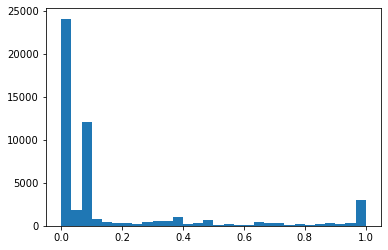

2022-04-13 19:25:19.009832 [ INFO  ] Descarding 43960 articles.
2022-04-13 19:25:19.011432 [ INFO  ] Making predictions over 6040 with model: <Clasifier vec_type=G3 trained=True model=MLPClassifier(max_iter=1500)>
2022-04-13 19:25:19.759985 [ INFO  ] Descarding 5298 articles.
yhat1.shape=(742,)
yhat2.shape=(742,)
2022-04-13 19:25:19.761057 [ INFO  ] Making predictions over 742 with model: <TermHighlighter model=LogisticRegression(C=1) trained=True vocab=<title, ..., new>>
yhat4.shape=(742,)
2022-04-13 19:25:19.904366 [ INFO  ] Number of relevant articles found: 30020 (ESTIMATED)
2022-04-13 19:25:19.914717 [ INFO  ] Moving 10 unlabeled suggestions from unlabeled data (2042213 - 10)
|█--------------------------------------------------------------------------|  0.35% labeled
 |██------------------------------------------------------------------------|  1.47% remaining relevant (estimated)


HTML(value='0 of 10 Examples annotated.')

Output()

Annotation done.


In [13]:
system.loop()

2022-03-31 19:51:58.021909 [  OK   ] Done


In [5]:
system = HRSystem(from_scratch=False)

2022-03-31 19:38:50.923323 [WARNING] Computing labeled data
2022-03-31 19:38:51.017451 [ INFO  ] Retrieving unlabeled data from disk
2022-03-31 19:39:01.536784 [ INFO  ] Number of unlabeled documents:    300,000
2022-03-31 19:39:01.536902 [ INFO  ] Number of labeled documents:        7,104
2022-03-31 19:39:01.537728 [ INFO  ] Training model
2022-03-31 19:39:01.538760 [ INFO  ] Training: <Clasifier vec_type=B trained=False model=SVC(C=1, kernel='linear', probability=True)>
2022-03-31 19:39:26.899966 [ INFO  ] Training: <Clasifier vec_type=G3 trained=False model=SVC(C=7, probability=True)>
2022-03-31 19:39:27.448747 [ INFO  ] Training: <Clasifier vec_type=G6 trained=False model=SVC(C=1, kernel='poly', probability=True)>
2022-03-31 19:39:28.717571 [ INFO  ] training term highlighter
2022-03-31 19:43:00.193110 [  OK   ] done
|██-------------------------------------------------------------------------|  2.31% labeled


2022-03-31 19:43:19.008790 [ INFO  ] Re-trained. Computing suggestions...
yhat1.shape=(20000,)


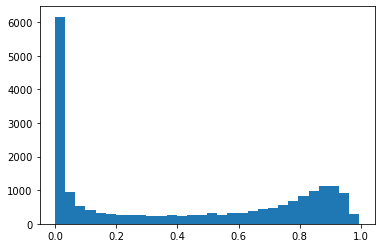

yhat1.shape=(7259,)
yhat2.shape=(7259,)
yhat3.shape=(7259,)
yhat4.shape=(7259,)
yhat=[0.71076439 0.82420983 0.87136826 ... 0.75436362 0.87291166 0.67581019]
yhat=[0.96299861 0.95894536 0.95820286 ... 0.5348342  0.52992759 0.51538287]
2022-03-31 19:46:09.881373 [ INFO  ] Number of relevant articles found: 108885 (ESTIMATED)
2022-03-31 19:46:09.883425 [ INFO  ] Moving 10 unlabeled suggestions from unlabeled data (299990 - 10)
|██-------------------------------------------------------------------------|  2.31% labeled
  |███████████████████████████----------------------------------------------| 36.30% remaining relevant (estimated)


HTML(value='0 of 10 Examples annotated.')

Output()

In [6]:
system.loop()

In [7]:
print()

In [ ]:
['dp',
 'displace',
 'person',
 'canada',
 'camp',
 'ii',
 'come',
 'title',
 'arrive',
 'ft',
 'europe',
 'immigrant',
 'girl',
 'ad',
 'find',

In [7]:
system.term_highlighter.sorted_terms()

['dp',
 'canada',
 'person',
 'displace',
 'ii',
 'camp',
 't',
 'm',
 'room',
 'worker',
 'ltd',
 'st',
 'sale',
 'come',
 'ft',
 'work',
 'refugee',
 'pr',
 'immigration',
 'arrive',
 'l',
 'europe',
 'experience',
 'phone',
 'canadian',
 'toronto',
 'immigrant',
 'girl',
 'll',
 'germany',
 'find',
 'german',
 'unch',
 'bring',
 'oil',
 'wa',
 'r',
 'price',
 'office',
 'night',
 'require',
 'council',
 'today',
 'company',
 'hi',
 'polish',
 'high',
 'co',
 'apply',
 'man',
 'job',
 'li',
 'ad',
 'tv',
 'labor',
 'people',
 'il',
 'estate',
 'si',
 'tn',
 'want',
 'title',
 'salary',
 'school',
 'news',
 'member',
 'country',
 'box',
 'low',
 'speak',
 'jewish',
 'cent',
 'leave',
 'communist',
 'union',
 'n',
 'cp',
 'ont',
 'rr',
 'group',
 'official',
 'tor',
 'miss',
 'ir',
 'al',
 'limit',
 'good',
 'united',
 'month',
 'tr',
 'woman',
 'fi',
 'sport',
 'nt',
 'lake',
 'bedroom',
 'service',
 'child',
 'ml',
 'date',
 'position',
 'lot',
 'v',
 'nr',
 'dr',
 'war',
 'tell',
 '

In [9]:
'person' in HRSystem.VOCAB

True

In [8]:
# ## FOR CHANGE ONCE I HAVE THE FINAL 
# lines = open('../04. Model of DP/precomputed/freq.txt').read().splitlines()


# freq = ([line.split(';') for line in lines])
# print(f'Original vocab size: {len(freq):,}')
# freq = [(word,int(freq)) for word,freq in freq if len(word)>2]
# freq = sorted(freq, key=lambda x: x[1], reverse=True)[:10000]
# print(freq[:10])
# vocab = [word for word,_ in freq]
# vocab
# word2index = dict([(word,index) for index, word in enumerate(vocab)])

# writer = open('../04. Model of DP/precomputed/vocab.txt', 'w')
# writer.write('\n'.join(vocab)+'\n')
# writer.close()
# del(vocab,freq) 
 
# print(f'Original vocab size: {len(word2index):,}')



Original vocab size: 30,694
[('title', 396947), ('new', 359524), ('toronto', 347775), ('said', 277651), ('year', 267324), ('time', 247789), ('canada', 234967), ('ing', 226704), ('day', 224558), ('today', 221117)]
Original vocab size: 10,000


In [ ]:
# 1288605023
# 1282700610
# 1283089935
# 1287452129

In [5]:
# from utils.tdmstudio import TDMStudio
# count=4
# for item in system.unlabeled_data:
#     title,text = TDMStudio.get_title_and_text(item.filename())
#     if 'argentina' in f'{title}. {text}'.lower():
#         print(item.id_)
#         count-=1
#     if count==0:
#         break

1288605023
1282700610
1283089935
1287452129


In [14]:
# system.save()

In [30]:
# from sklearn.model_selection import cross_validate
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# parameters = { 'C':[30,40, 50]}
# svc = SVC(kernel='rbf')

# # parameters = {'C':[1,2,3,4,5,6], 'degree':[1,2,3,4,5,6,7]}
# # svc = SVC(kernel='poly')
# clf = GridSearchCV(svc, parameters,scoring=['f1','accuracy','precision', 'recall'], cv=5,verbose=0, refit='f1')
# X = np.random.rand(100,5)
# y = np.random.rand(100,)*100
# y = y.astype('int')
# y = y %2
# rta = clf.fit(X,y)
# pd.DataFrame(results.cv_results_)
# df = (pd.DataFrame(rta.cv_results_)[["params","mean_test_accuracy", "mean_test_precision","mean_test_recall","mean_test_f1"]])
# df.columns=['params','mean accuracy', 'mean precision','mean recall','mean f1',]
# print(df)

      params  mean accuracy  mean precision  mean recall   mean f1
0  {'C': 30}           0.55        0.540952     0.437778  0.470238
1  {'C': 40}           0.54        0.526667     0.437778  0.464356
2  {'C': 50}           0.53        0.500000     0.457778  0.470626


In [28]:
pd.DataFrame(rta.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.004550,0.002883,0.006639,0.003300,30,{'C': 30},0.400000,0.454545,0.5,0.266667,...,0.046380,3,0.444444,0.5,0.6,0.2,0.3,0.408889,0.142534,3
1,0.009431,0.011826,0.005670,0.002318,40,{'C': 40},0.421053,0.521739,0.5,0.266667,...,0.054007,1,0.444444,0.6,0.6,0.2,0.3,0.428889,0.159876,1
2,0.002962,0.000221,0.004195,0.000438,50,{'C': 50},0.421053,0.521739,0.5,0.250000,...,0.059792,2,0.444444,0.6,0.6,0.2,0.3,0.428889,0.159876,1


In [21]:
# system.loop()

2022-03-23 18:23:58.195964 [ INFO  ] Number of unlabeled documents:  1,934,909
2022-03-23 18:23:58.196109 [ INFO  ] Number of labeled documents:      114,492
2022-03-23 18:23:58.196144 [ INFO  ] Number of suggestions:                  0

2022-03-23 18:23:58.206889 [ INFO  ] Number of unlabeled documents:  1,934,909
2022-03-23 18:23:58.207013 [ INFO  ] Number of labeled documents:      114,492
2022-03-23 18:23:58.207058 [ INFO  ] Number of suggestions:                  0

    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
0  23.818077    0.079863       0.996393        0.828647     0.602446  0.658534
2022-03-23 18:32:23.618718 [ INFO  ] Estimated number of relevant articles found: 37555
2022-03-23 18:32:23.848950 [ INFO  ] Number of unlabeled documents:  1,934,899
2022-03-23 18:32:23.849091 [ INFO  ] Number of labeled documents:      114,492
2022-03-23 18:32:23.849112 [ INFO  ] Number of suggestions:                 10



HTML(value='0 of 10 Examples annotated.')

Output()

In [37]:
results = pd.DataFrame(rta)


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,2.673687,0.474377,0.957072,0.754545,0.709402,0.731278
1,2.503884,0.540821,0.965517,0.825243,0.732759,0.776256
2,2.524282,0.557241,0.961295,0.801980,0.698276,0.746544
3,2.468833,0.548861,0.961295,0.790476,0.715517,0.751131
4,2.473676,0.544166,0.966197,0.788136,0.801724,0.794872


In [51]:
np.average(results.values,axis=0).reshape(1,6)

array([[2.52887244, 0.53309326, 0.96227533, 0.79207603, 0.73153551,
        0.76001601]])

In [2]:
from utils.models import DataItem
import os
unlabeled_data = []
labeled_data = []

GM1 = '/home/ec2-user/SageMaker/data/GM_all_1945_1956/'
GM2 = '/home/ec2-user/SageMaker/data/GM_all_1957-1967/'

unlabeled_data = [DataItem(GM1+file_) for file_ in os.listdir(GM1)] + [DataItem(GM2+file_) for file_ in os.listdir(GM2)]
labeled_data = []
for line in open('labeled_data.csv').read().splitlines()[1:]:
    id_,label = line.split(';')
    item = DataItem(id_)
    if label=='R':
        item.set_relevant()
    else:
        item.set_irrelevant()
        assert label=='I'
    if item.has_vector():
        labeled_data.append(item)
# labeled_data = [DataItem(line.split(';')[0]) for line in open('labeled_data.csv').read().splitlines()[1:]]

info(f'Number of unlabeled documents: {len(unlabeled_data):10,}')
info(f'Number of labeled documents:   {len(labeled_data):10,}')
# os.listdir(GM1)[1]

2022-03-21 17:44:52.618183 [ INFO  ] Number of unlabeled documents:  2,057,868
2022-03-21 17:44:52.619272 [ INFO  ] Number of labeled documents:        4,695


In [12]:
unlabeled_data = [item for item in unlabeled_data if item.has_vector()]
info(f'Number of unlabeled documents: {len(unlabeled_data):10,}')


2022-03-21 18:05:11.185323 [ INFO  ] Number of unlabeled documents:  1,556,455


In [3]:
%%time
from sklearn.svm import SVC


CPU times: user 4.7 s, sys: 532 ms, total: 5.23 s
Wall time: 7min 2s


SVC()

In [14]:
unlabeled_data[0].has_vector()

True

In [17]:
# count = 0
# for item in unlabeled_data:
    
# clf.predict(DataItem.get_X([unlabeled_data[205]], type_=DataItem.TYPE_GLOVE600))

array([0.])

2022-03-21 18:53:44.723528 [ INFO  ] Number of unlabeled documents:  1,776,413
2022-03-21 18:53:44.730451 [ INFO  ] Number of labeled documents:        5,739


In [9]:
system.loop()

In [10]:
import myversions.pigeonXT as pixt

annotations = pixt.annotate(
            ["hello world", "Some other text."],
            options = ['Relevant', 'Irrelevant'],
            stop_at_last_example=False,
            display_fn=html,
        )

HTML(value='0 of 2 Examples annotated.')

Output()

Annotation done.


In [12]:
annotations["label"]

0    Relevant
1    Relevant
Name: label, dtype: object

In [9]:
import pigeonXT as pixt2
pixt2.annotate(['hello world', 'other stuff'], options=['R', 'N'])

'hello world'

,example,changed,label
0,hello world,False,
1,other stuff,False,


In [10]:
print(DataItem(open('labeled_data.csv', 'r').read().splitlines()[1:][0].split(';')[0]))

DataItem(id=1293118416, source=GM1, label=U)


In [5]:
[line.split(';')[0] for line in open('labeled_data.csv').read().splitlines()[1:]][0]

'1293118416'

2022-03-21 16:23:35.503167 [ INFO  ] Number of unlabeled documents:  1,556,455


1556455

### OLD

In [10]:
# import os
# import re
# from utils.general import id2file

# second_round_data = [linea.strip().split(';') for linea in  open('../04. Model of DP/second_roud_labels.csv','r').read().splitlines()]
# irrelevant_set = set([id_ for id_,label in second_round_data if label=='I'])
# relevant_set = set([id_ for id_,label in second_round_data if label=='R'])


# # Loading new_data
# new_data = [line.split(';') for line in open('../04. Model of DP/new_data.csv').read().splitlines()]
# relevant_set = relevant_set.union(set([id_ for id_,label in new_data if label.strip()=='R']))
# irrelevant_set = irrelevant_set.union(set([id_ for id_,label in new_data if label.strip()=='I']))

# # Loading original data
# DP_examples_dirpath = '/home/ec2-user/SageMaker/mariano/notebooks/04. Model of DP/DP-relevant articles/'

# first_data = []
# for dirpath, dirnames, filenames in os.walk(DP_examples_dirpath):
#     for filename in filenames:
#         content = open(os.path.join(dirpath,filename),'r').read()
#         ids = re.findall('/docview/([^/]*)/',content)
#         relevant_set = relevant_set.union(set(ids))
    
# # articles containg DP and Canada from that period, that were not deteted by Serperi
# GM_dp_dirpath = '/home/ec2-user/SageMaker/data/GM_DP_and_Canada1945_1967/'

# files = os.listdir(GM_dp_dirpath)

# irrelevant_set = irrelevant_set.union([file_[:-4] for file_ in files if file_[:-4] not in relevant_set and file_.endswith('.xml')])

# not_found=[]
# for id_ in list(relevant_set)+list(irrelevant_set):
#     if id2file(id_) is None:
#         not_found.append(id_)
# print(f'Not found: {not_found}')
# for id_ in not_found:
#     relevant_set = relevant_set.difference(set(not_found))
#     irrelevant_set = irrelevant_set.difference(set(not_found))
    
# info(f'len(relevant_set)   = {len(relevant_set)}')
# info(f'len(irrelevant_set) = {len(irrelevant_set)}')

# import pandas as pd 

# df = pd.DataFrame(list(relevant_set)+list(irrelevant_set),columns=['id'])
# df['label']='I'
# df.iloc[:len(relevant_set),1]='R'
# df.to_csv('labeled_data.csv', sep=';', index=False)

Not found: ['2459964104', '1411697642', '2122281371', '1136691129', '1242257052', '1239753620', '1238204962', '2459666609', '2122279956', '1151348424', '1238440920', '1222379804', '1143160388']
2022-03-21 16:28:55.030601 [ INFO  ] len(relevant_set)   = 581
2022-03-21 16:28:55.030799 [ INFO  ] len(irrelevant_set) = 6523


In [14]:
!grep I labeled_data.csv  |wc -l



6523


In [74]:

DataItem.TYPE_BOW

AttributeError: type object 'DataItem' has no attribute 'TYPE_BOW'

In [96]:
item1 = DataItem('/home/ec2-user/SageMaker/data/GM_all_1945_1956/1323614655.xml')
item2 = DataItem('1287437740','GM1')
print(item1)
print(item2)
# item1.label = DataItem.REL_LABEL
# item2.label = DataItem.IREL_LABEL
# DataItem.get_X([item1,item2], type_=DataItem.TYPE_GLOVE600)

DataItem(id=1323614655, source=GM1, label=U)
DataItem(id=1287437740, source=GM1, label=U)


In [69]:
from sklearn.svm import SVC

In [87]:
# item1 = DataItem('/home/ec2-user/SageMaker/data/GM_all_1945_1956/1323614655.xml')
# item2 = DataItem('1287437740','GM1')
# item1.label = DataItem.REL_LABEL
# item2.label = DataItem.IREL_LABEL
# X = DataItem.get_X([item1, item2], type_=DataItem.TYPE_GLOVE600)
# y = DataItem.get_y([item1, item2])
# clf = SVC()
# clf.fit(X, y)
# print(clf.predict(X))

[1. 0.]


array([1., 0.])

In [45]:
# item1.vector(type_='glove300')

True